# How to use lightkurve for asteroseismology

Asteroseismology is the study of stellar oscillations. To see them, we usually want to transfer from the *time domain* that light curves are in to the *frequency domain*. We can do that with methods such as Fourier Transforms or Lomb-Scargle Periodograms. `lightkurve` has built in methods for working with data in the *frequency domain*, in the `Periodogram` class.

Below we demonstrate some of the new functionalities in `lightkurve` and how to use them for asteroseismology.

In [1]:
from lightkurve import log, search_targetpixelfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import astropy.units as u

As an example, we can use a red giant star from Campaign 5. You can read more about asteroseismology with giants in K2 in Stello et al 2015 [here](https://arxiv.org/pdf/1610.03060.pdf). 

First we'll use `from_archive` to download the Target Pixel File for the target.

In [2]:
TARGET = "EPIC 211416749"
tpf = search_targetpixelfile(TARGET, campaign=5, cadence='short').download()

Be aware that this is a **short cadence** light curve, which means that this dataset is much larger than others we've used in previous tutorials. If you're rerunning this tutorial locally, it might take a few minutes to rerun the later steps.

In [3]:
tpf.flux.shape

(108780, 11, 11)

Let's plot the target below to see if the aperture is centered. We're plotting in 'log' scale here so that we can see the wings of the PSF.

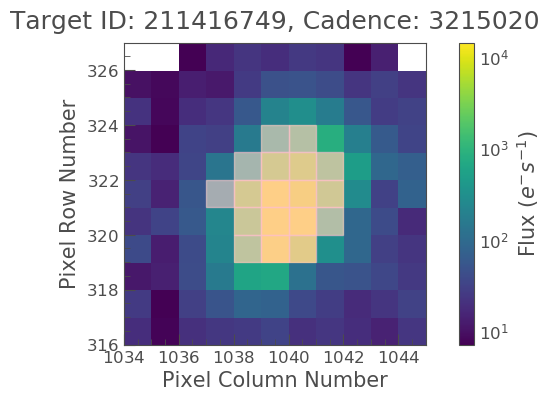

In [4]:
tpf.plot(scale='log', aperture_mask=tpf.pipeline_mask);

We can now create a `KeplerLightCurve` using Simple Aperture Photometry with the `to_lightcurve` method. We can then normalize, remove NaN values and remove outliers in one easy line. We can also use the new `fill_gaps` method to fill in any gaps there are in our data using linear interpolation of the nearest neighbours. This creates an almost perfectly sampled time array with no gaps.

In [5]:
lc = tpf.to_lightcurve()
lc = lc.normalize(unit='ppm').remove_nans().remove_outliers().fill_gaps()

We can plot our light curve easily with the `plot` method.

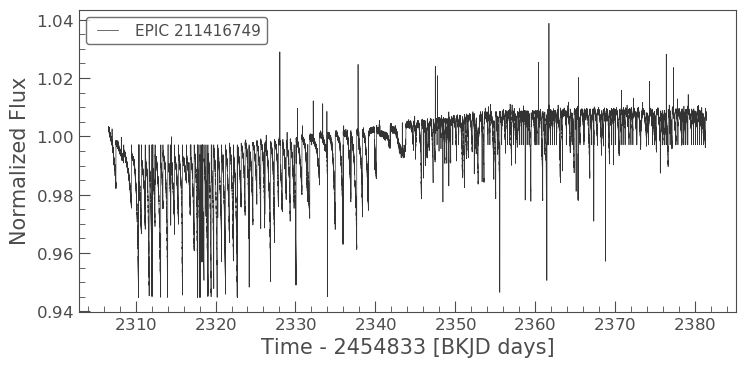

In [6]:
lc.plot();

Let's take a look at the periodogram for this light curve. You can create a `periodogram` object using `lc.periodogram()`. This can be passed any array of frequencies that the user wants, but by default will create an array of frequency for you. You can also change the frequency units, depending on the range of frequencies you're looking for. In asteroseismology we usually use $\mu Hz$.

In [7]:
pg = lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)

With this new periodogram object we can now plot the power spectrum of the data. Let's do that now!

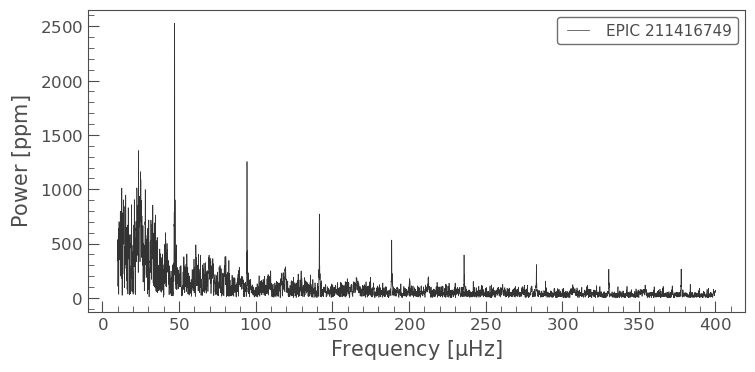

In [8]:
ax = pg.plot();

## 1. Varying the SFF Motion Correction

Unfortunately there is some ringing going on...there is a periodicity in the data due to the K2 motion. We can see below when we plot the data in "Period" space instead of "Frequency" space there is a significant periodicity at ~ 6 hours.

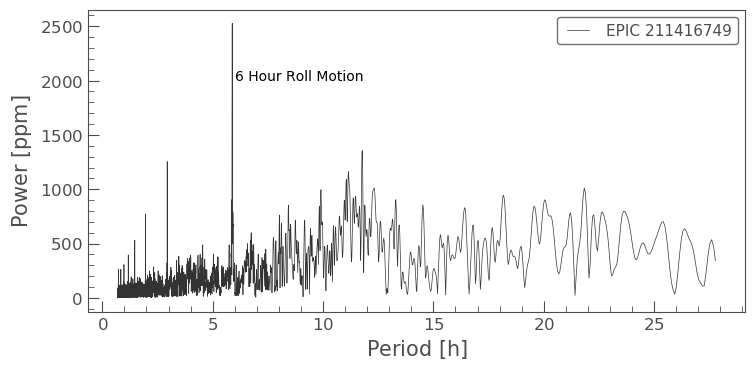

In [9]:
ax = pg.plot(view='Period', unit=u.hour)
ax.text(6, 2000, '6 Hour Roll Motion');

We can apply our own Self Flat Fielding (SFF) correction to the light curve to remove the K2 roll motion. Below we correct with SFF using the default `correct` function, with `windows=10`. (You can read more about SFF in our other tutorials.) 

In [10]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.to_corrector("sff").correct(windows=10).remove_outliers().fill_gaps()

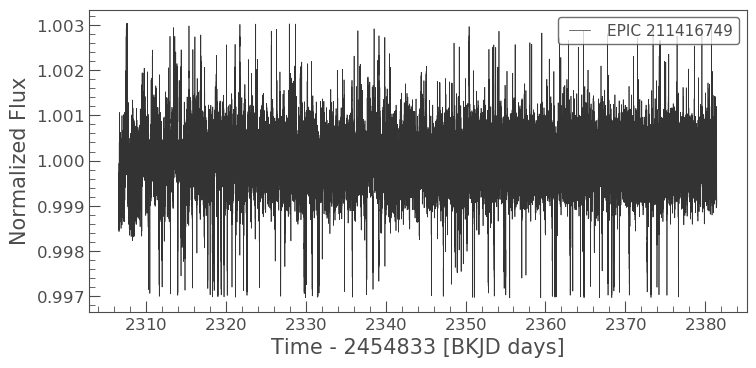

In [11]:
clc.plot();

Our new, corrected lightcurve looks much flatter and has a much smaller CDPP. Let's try plotting the periodogram again.

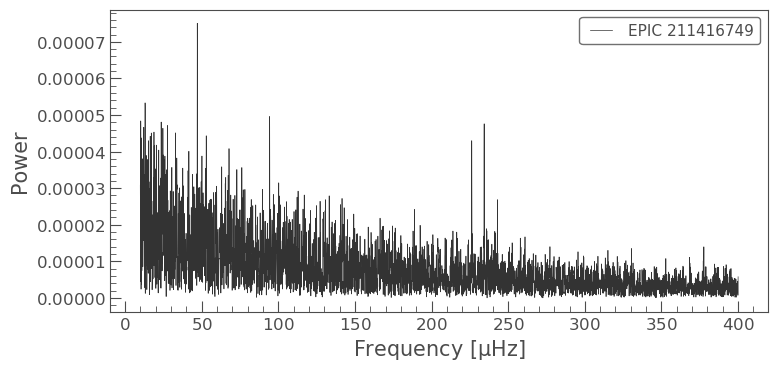

In [12]:
pg_clean = clc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = pg_clean.plot()

This is much better, although there is clearly some periodicity still left in the data. However, now we can see the oscillation modes of the target! Let's zoom in to the region of interest.

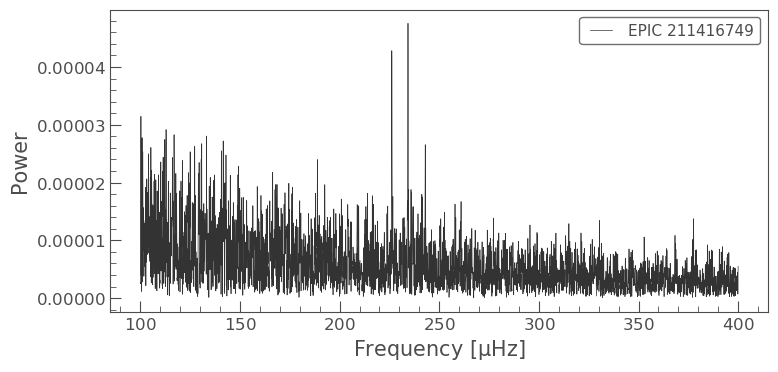

In [13]:
pg_clean = clc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
ax = pg_clean.plot()

We can even find out what effect our detrending parameters have on our target. Below we change the detrending windows from $w=2\; ... \; 10$ and plot the periodogram in each case. We can see different detrending parameters has an effect on each of the modes.

The next few demos take a long time to run.  Toggle the boolean value below to see the results.

In [14]:
LONG_RUN = True

100%|██████████| 5/5 [03:17<00:00, 39.83s/it]


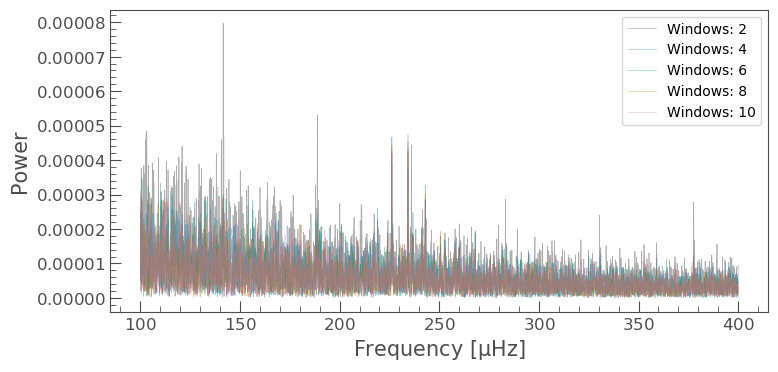

In [15]:
if LONG_RUN:
    # Loop over several windows
    for windows in tqdm(np.arange(2, 12, 2)):
        # Create the light curve
        lc =  tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
        clc = lc.to_corrector('sff').correct(windows=windows).remove_outliers().fill_gaps()
        # Create the periodogram
        p_clean = clc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
        # Plot the periodogram
        if windows == 2:
            ax = p_clean.plot(alpha=0.4, label='Windows: {}'.format(windows))
        else:
            p_clean.plot(ax=ax, alpha=0.4, label='Windows: {}'.format(windows))

    ax.legend()

It looks like there is a significant effect on the oscillation modes as we vary the window size. When using K2 data for detecting these oscillations it is important to understand and mitigate the effects of detrending to ensure the modes have the highest possible signal to noise ratio.

## 2. Varying the Aperture Size
We can also easily change the aperture size. If the aperture is too small, increasing the aperture size should allow us to include more of the target flux. If there is a contaminant nearby, decreasing the aperture may increase our singal to noise.

Below we create a new aperture for the target. In this case we've used an aperture where pixels have a value greater than the 70th percentile.

In [16]:
aper = np.nanmedian(tpf.flux, axis=0) > np.nanpercentile(np.nanmedian(tpf.flux, axis=0), 70)

/home/gb/bin/anaconda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/gb/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


We can plot up our new aperture against the pipeline aperture for comparison.

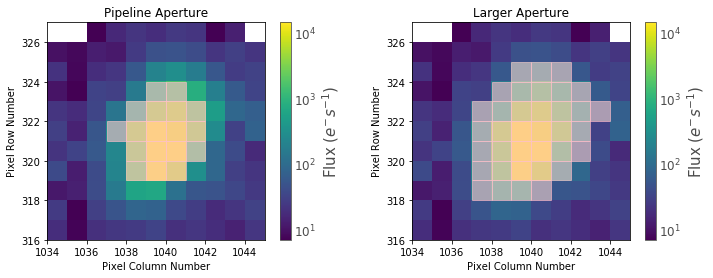

In [17]:
# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot pipeline aperture mask
tpf.plot(axs[0], scale='log', aperture_mask=tpf.pipeline_mask)
axs[0].set_title('Pipeline Aperture')

# Plot larger aperture mask
tpf.plot(axs[1], scale='log', aperture_mask=aper)
axs[1].set_title('Larger Aperture');

Now let's create our two light curves, one with the pipeline aperture and one with the new aperture. 

`tpf.to_lightcurve()` creates our SAP flux with the pipeline aperture as a default. To use a new aperture we simple use `tpf.to_lightcurve(aperture_mask=NEW_APERTURE)`.

In [18]:
# Create the light curve with the pipelien aperture.
lc_pipeline = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
lc_pipeline = lc_pipeline.to_corrector('sff').correct(windows=10).remove_outliers().fill_gaps()

# Create a light curve with a slightly larger aperture 
lc_larger_aperture = tpf.to_lightcurve(aperture_mask=aper).normalize().remove_nans().remove_outliers()
lc_larger_aperture = lc_larger_aperture.to_corrector('sff').correct(windows=10).remove_outliers().fill_gaps()

When we plot these two light curves we can see that the larger aperture is much less noisy.

/home/gb/bin/anaconda/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/gb/bin/anaconda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


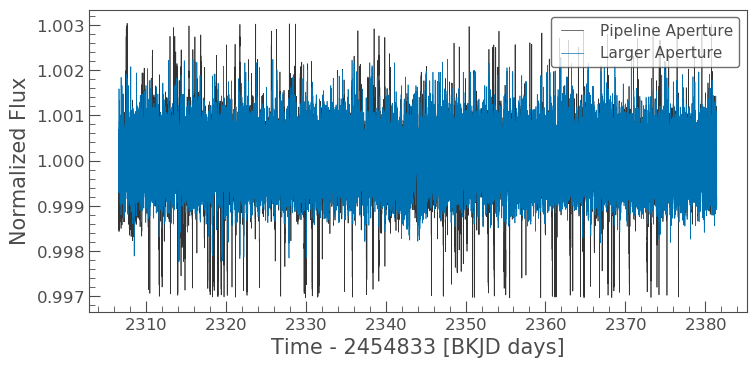

In [19]:
#Plot the pipeline and large aperture light curves
ax = lc_pipeline.plot(label='Pipeline Aperture')
lc_larger_aperture.plot(ax=ax, label='Larger Aperture');

Finally, when we plot the periodogram we can see we've increased the signal to noise ratio of our stellar oscillations.

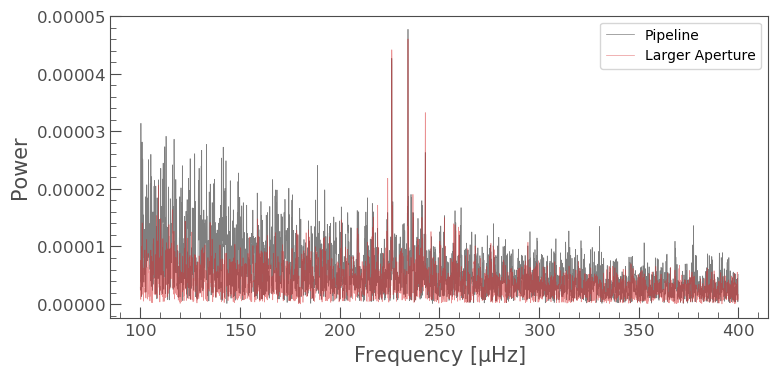

In [20]:
# Create the periodograms
p_pipeline = lc_pipeline.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)
p_larger_aperture = lc_larger_aperture.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)


# Plot the periodograms
ax = p_pipeline.plot(c='k', alpha=0.5, label='Pipeline')
p_larger_aperture.plot(ax=ax, c='C3', alpha=0.5, label='Larger Aperture')

ax.legend();

By increasing our aperture size and including more pixels here we have increased the signal to noise of the oscillation modes of this red giant.

## 3. Using data from multiple campaigns
Finally, this target was actually observed twice by K2, once in April 2015 in Campaign 5 and once in December 2017 in Campaign 16. We can get both of these data sets and compare the results. 

In [21]:
# Download the C16 TPF
tpf_c16 = search_targetpixelfile(TARGET, campaign=16, cadence='short').download()

# Create a new "large" aperture where flux is greater than the 70th percentile.
aper = np.nanmedian(tpf_c16.flux, axis=0) > np.nanpercentile(np.nanmedian(tpf_c16.flux, axis=0), 70)

# Create a new light curve for C16
lc_c16 = tpf_c16.to_lightcurve(aperture_mask='all').normalize().remove_nans().remove_outliers()
lc_c16 = lc_c16.to_corrector('sff').correct(windows=10).remove_outliers().fill_gaps()

/home/gb/bin/anaconda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/gb/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [22]:
# Create a periodogram for c16 data
p_c16 = lc_c16.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=100)

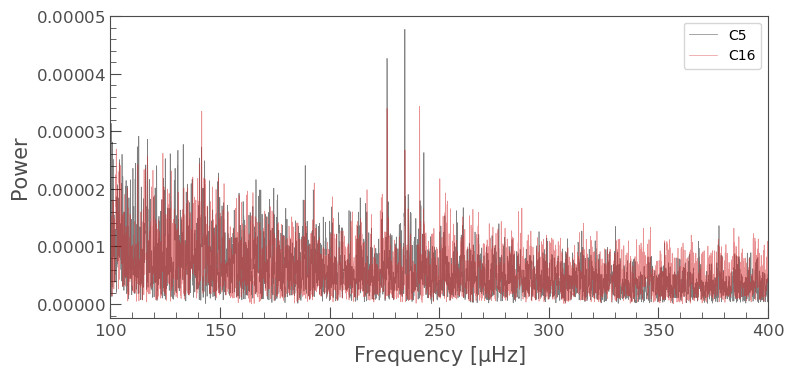

In [23]:
# Create subplots to plot into
ax = p_pipeline.plot(c='k', alpha=0.5, label='C5')
p_c16.plot(ax=ax, c='C3', alpha=0.5, label='C16')

ax.set_xlim(100, 400)
ax.legend();

It looks like the two data sets provide similar modes, however the two campaigns have very different instrument systematics. To find the true answer, users should iterate over many different detrending parameters and aperture sizes, and combine datasets to increase signal to noise.